# Imputation multiple avec MICE

- *Auteurs:* Quentin Grimonprez, Cristian Preda, Vincent Vandewalle
- *Date:* 16 février 2020

On utilise le package [pandas](https://pandas.pydata.org/pandas-docs/stable/) pour manipuler des dataFrames (tableau pouvant contenir des types différents entre les colonnes) et le package [statsmodels](https://www.statsmodels.org/stable/api.html) pour l'imputation multiple (statsmodels contient principalement des méthodes de régressions (avec plus d'analyses statistiques que scikit-learn) et séries temporelles). Dans [scikit-learn](https://scikit-learn.org/stable/modules/impute.html), il est pour l'instant uniquement possible de faire de l'imputation basée sur des méthodes simples (moyenne, valeur la plus fréquente...), une implémentation de MICE est en développement.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.imputation import mice

plt.rcParams["figure.figsize"] = 8, 8

## Aperçu des données

Chargement des données airquality à partir du fichier fourni. En ouvrant ce fichier, on notera que les manquants de la variable *Ozone* sont codés par la valeur `-9` tandis que ceux de la variable Solar.R le sont par `NA`.

In [2]:
airquality = pd.read_table("airquality2.txt", sep=" ", header=[0], 
                           na_values={"Ozone": -9, "Solar.R": "NA"},
                           dtype={"Month": str, "Day": str})
airquality.rename(columns={"Solar.R": "SolarR"}, inplace=True) # les fonctions de modélisation de statsmodels ne supportent pas les "." dans les noms. Le paramètre inplace=True indique qu'il faut modifier directement le DataFrame et non retourner une copie.
airquality.head()

,Ozone,SolarR,Wind,Temp,Month,Day
0,41.0,190.0,7.4,67,5,1
1,36.0,118.0,8.0,72,5,2
2,12.0,149.0,12.6,74,5,3
3,18.0,313.0,11.5,62,5,4
4,NaN,NaN,14.3,56,5,5


On vérifie le type des colonnes. Les chaînes de caractères sont de type *object*.

In [3]:
airquality.dtypes

Ozone     float64
SolarR    float64
Wind      float64
Temp        int64
Month      object
Day        object
dtype: object

#### Statistiques univariées

In [4]:
print(airquality.shape)
airquality.describe()  # par défaut, calcule les statistiques pour les variables numériques. Si vous voulez des statistiques sur toutes les variables, ajoutez le paramètre include="all"

(153, 6)


,Ozone,SolarR,Wind,Temp
count,116.000000,146.000000,153.000000,153.000000
mean,42.129310,185.931507,9.957516,77.882353
std,32.987885,90.058422,3.523001,9.465270
min,1.000000,7.000000,1.700000,56.000000
25%,18.000000,115.750000,7.400000,72.000000
50%,31.500000,205.000000,9.700000,79.000000
75%,63.250000,258.750000,11.500000,85.000000
max,168.000000,334.000000,20.700000,97.000000


La valeur **count** représentent le nombre de données présentes. On constate que les variables *Ozone* et *SolarR* présentent des valeurs manquantes.

In [5]:
X = airquality.copy()
X = X[X.columns[0:4]]
X.head()

,Ozone,SolarR,Wind,Temp
0,41.0,190.0,7.4,67
1,36.0,118.0,8.0,72
2,12.0,149.0,12.6,74
3,18.0,313.0,11.5,62
4,NaN,NaN,14.3,56


## Visualisation des manquants

On crée un objet permettant d'imputer les données manquantes. La méthode utilisée est le *predictive mean matching*, on peut préciser le paramètre *k_pmm* qui correspond au nombre d'observations, proches de la réponse prédite, utilisée pour tirer la valeur imputée (cf. [doc](https://www.statsmodels.org/stable/generated/statsmodels.imputation.mice.MICEData.html#statsmodels.imputation.mice.MICEData)).

In [6]:
imp = mice.MICEData(X, k_pmm=5)

### Visualisation de la répartition des manquants.

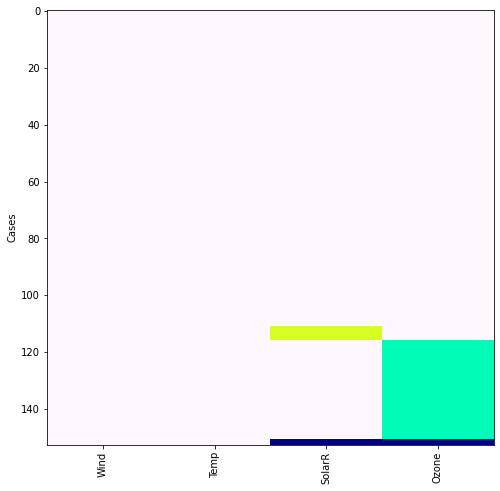

In [7]:
ax = imp.plot_missing_pattern()

On note que certains individus ont simultanément *SolarR* et *Ozone* manquants. La classe MICEData ne dispose pas d'une fonction pour récupérer le l'ensemble des patterns et leur fréquence. On la crée donc.

In [8]:
def getMissingPattern(miceData):
    cols = miceData.data.columns

    miss = np.zeros(miceData.data.shape)
    for j, col in enumerate(cols):
        ix = miceData.ix_miss[col]
        miss[ix, j] = 1
    miss = pd.DataFrame(miss, columns=cols)

    count = miss.groupby(list(cols)).size()
    count = count.reset_index()
    count.rename({0: "count"}, axis=1, inplace=True)
   
    return count

In [9]:
getMissingPattern(imp)

,Ozone,SolarR,Wind,Temp,count
0,0.0,0.0,0.0,0.0,111
1,0.0,1.0,0.0,0.0,5
2,1.0,0.0,0.0,0.0,35
3,1.0,1.0,0.0,0.0,2


Un profil (pattern) de données manquantes est donc un vecteur avec les éléments 0 ou 1 avec 0 = donnée présente, 1 = donnée manquante. Les 4 premières colonnes décrivent le pattern de manquants et la dernière (**count**), le nombre d'individus suivant ce pattern. Dans notre exemple, il y a 35 individus avec uniquement *Ozone* comme manquant.

#### MCAR, MAR ou MNAR

Afin de mettre un modèle sur les données manquantes, visualiser les croisements deux à deux des variables est utile.

In [10]:
def compareDistribution(X, variable1, variable2):
    fig, ax = plt.subplots(3, 3, sharex='col', sharey='row', 
                           gridspec_kw={"width_ratios": [4, 0.5, 1.25], 
                                        "height_ratios": [4, 0.5, 1.25]})

    # create a categorical variable indicating if the value is missing or not 
    Xtemp = X.copy()
    Xtemp["var1Status"] = np.array(["present", "miss"])[np.isnan(X[variable1]) * 1]
    Xtemp["var2Status"] = np.array(["present", "miss"])[np.isnan(X[variable2]) * 1]

    # plot the present values
    sns.scatterplot(data=X, x=variable1, y=variable2, ax=ax[0, 0])

    # plot the varaible2 values when the variable1 is missing
    sns.scatterplot(x=0, y=Xtemp[variable2][Xtemp["var1Status"] == "miss"], color="tab:orange", ax=ax[0, 1])
    ax[0, 1].axes.xaxis.set_visible(False)

    # boxplot of variable2 with regards to the fact that variable1 is missing or not
    sns.boxplot(data=Xtemp, x="var1Status", y=variable2, ax=ax[0, 2])
    ax[0, 2].yaxis.label.set_visible(False)
    ax[0, 2].xaxis.label.set_visible(False)

    # plot the variable1 values when the variable2 is missing
    sns.scatterplot(x=Xtemp[variable1][Xtemp["var2Status"] == "miss"], y=0, color="tab:orange", ax=ax[1, 0])
    ax[1, 0].axes.yaxis.set_visible(False)

    # boxplot of variable1 with regards to the fact that variable2 is missing or not
    sns.boxplot(data=Xtemp, x=variable1, y="var2Status", orient="h", ax=ax[2, 0])
    ax[2, 0].yaxis.label.set_visible(False)

    ax[1, 1].axis("off")
    ax[1, 2].axis("off")
    ax[2, 1].axis("off")
    ax[2, 2].axis("off")
    fig.suptitle("")


Par exemple :

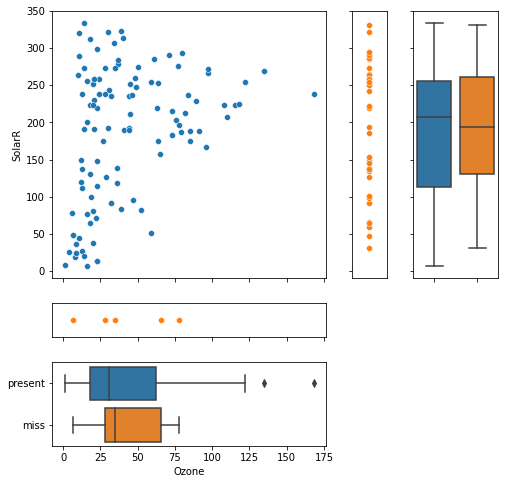

In [11]:
compareDistribution(X, "Ozone", "SolarR")

## Imputation

### Imputation des données manquantes

Pour chaque variable, la méthode par défaut utilisée est une régression linéaire. Cela peut être changé variable par variable avec la fonction [`set_imputer`](https://www.statsmodels.org/stable/generated/statsmodels.imputation.mice.MICEData.set_imputer.html#statsmodels.imputation.mice.MICEData.set_imputer). Cette fonction permet de définir le modèle utilisé, la formule et d'autres paramètres.

La méthode `update_all(n_iter)` effectue `n_iter` itérations (une itération = une mise à jour de chaque variable) de l'algorithme MICE.

In [12]:
imp.update_all(n_iter=1)  # Code équivalent : imp.next_sample()
imp.data.head()

,Ozone,SolarR,Wind,Temp
0,41.0,190.0,7.4,67
1,36.0,118.0,8.0,72
2,12.0,149.0,12.6,74
3,18.0,313.0,11.5,62
4,28.0,259.0,14.3,56


### Visualisation de la distribution d'une variable en fonction d'une variable avec manquant

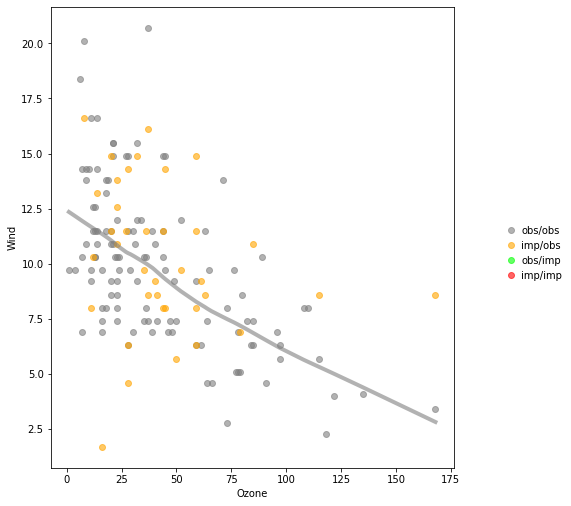

In [13]:
ax = imp.plot_bivariate("Ozone", "Wind")

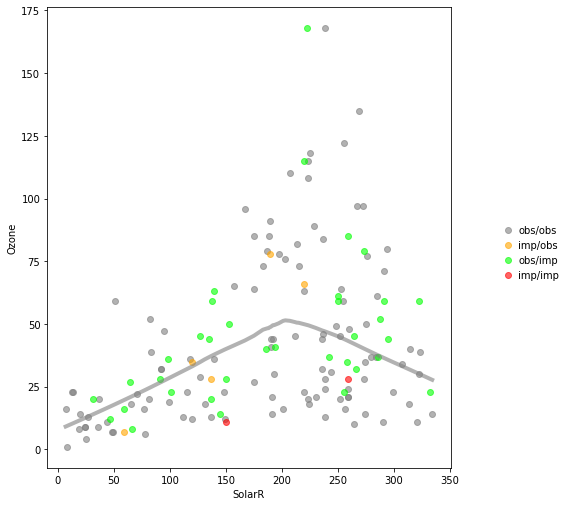

In [14]:
ax = imp.plot_bivariate("SolarR", "Ozone")

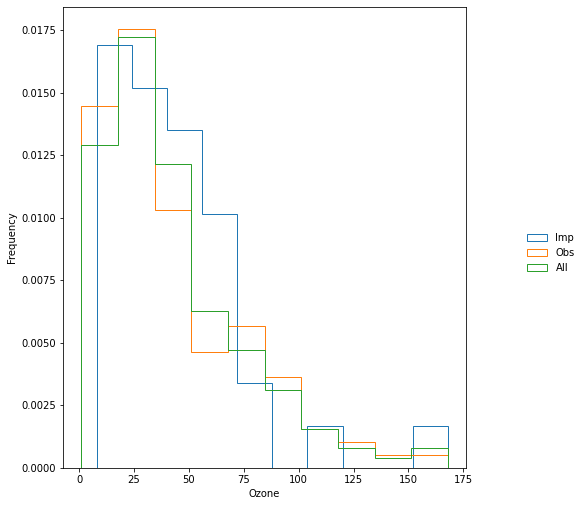

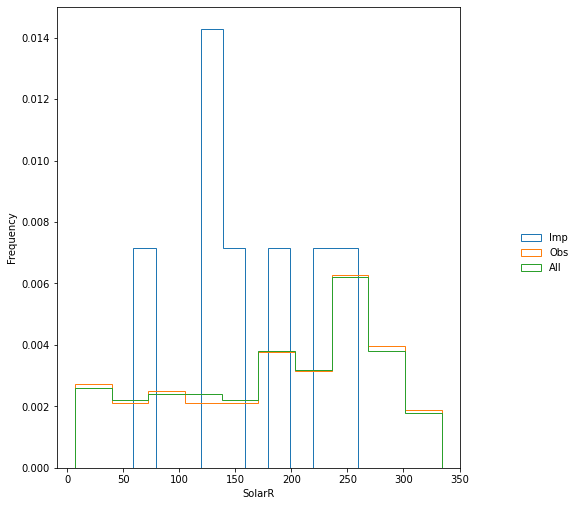

In [15]:
for varName in ["Ozone", "SolarR"]:
    ax=imp.plot_imputed_hist(varName, imp_hist_args={"density": True}, obs_hist_args={"density": True}, all_hist_args={"density": True})

## Imputation multiple

In [16]:
nImputation = 10
nBurnIter = 5

imp.update_all(nBurnIter)

imputedData = []
for m in range(nImputation):
    data = imp.next_sample()
    imputedData.append(data.copy())

Un jeu de données imputées.

In [17]:
print(imputedData[0].head())
imputedData[0].describe()

   Ozone  SolarR  Wind  Temp
0   41.0   190.0   7.4    67
1   36.0   118.0   8.0    72
2   12.0   149.0  12.6    74
3   18.0   313.0  11.5    62
4    6.0    99.0  14.3    56


,Ozone,SolarR,Wind,Temp
count,153.000000,153.000000,153.000000,153.000000
mean,40.183007,186.000000,9.957516,77.882353
std,31.218550,89.141446,3.523001,9.465270
min,1.000000,7.000000,1.700000,56.000000
25%,18.000000,115.000000,7.400000,72.000000
50%,30.000000,203.000000,9.700000,79.000000
75%,59.000000,258.000000,11.500000,85.000000
max,168.000000,334.000000,20.700000,97.000000


In [18]:
def plotImputedData(miceData, imputedData, variable):
    df = pd.DataFrame()
    for i in range(len(imputedData)):
        dfTemp = pd.DataFrame()
        dfTemp[variable] = imputedData[i][variable]
        dfTemp["Imputation"] = i
        dfTemp["miss"] = False
        dfTemp["miss"].iloc[imp.ix_miss["Ozone"]] = True
        df = df.append(dfTemp)
        
    ax = sns.stripplot(data=df, x="Imputation", y="Ozone", hue="miss")
    ax.get_legend().remove()


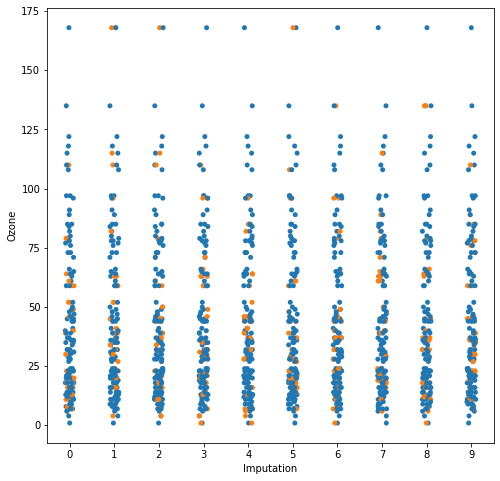

In [19]:
plotImputedData(imp, imputedData, "Ozone")

## Regression linéaire dans le contexte de l’imputation multiple

Pour appliquer un modèle de régression sur plusieurs jeux de données imputées, nous utilisons [`mice.Mice`](https://www.statsmodels.org/stable/generated/statsmodels.imputation.mice.MICE.html). Il prend notamment en arguments la formule, le modèle, un objet `MICEData`. La méthode `fit` de l'objet va imputer et appliquer le modèle fourni (ici une régression linéire classe avec `sm.OLS`). On lui précise le nombre de burn-in itérations (itérations à faire avant de garder la 1ère imputation) et le nombre d'imputation à faire.

In [20]:
formula = "Ozone ~ SolarR + Wind + Temp"
miceFit = mice.MICE(formula, sm.OLS, imp, n_skip=3)  # n_skip : nombre d'itérations à faire entre 2 imputations
results = miceFit.fit(n_burnin=5, n_imputations=10)

In [21]:
results.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                           Results: MICE
====================================================================
Method:                    MICE        Sample size:           153   
Model:                     OLS         Scale                  462.59
Dependent variable:        Ozone       Num. imputations       10    
--------------------------------------------------------------------
           Coef.   Std.Err.    t    P>|t|    [0.025   0.975]   FMI  
--------------------------------------------------------------------
Intercept -69.3257  25.9630 -2.6702 0.0076 -120.2122 -18.4392 0.4370
SolarR      0.0669   0.0217  3.0775 0.0021    0.0243   0.1095 0.1455
Wind       -2.8126   0.6794 -4.1398 0.0000   -4.1442  -1.4810 0.3212
Temp        1.6185   0.2823  5.7330 0.0000    1.0652   2.1719 0.4122
====================================================================

"""

La statistique *FMI* représente la part de variance de l’estimateur due à l’imputation. Une valeur trop grande montre que l’imputation est probablement inappropriée dans ce cas. Une valeur < 0.3 est généralement tolerée.

In [22]:
results.frac_miss_info

array([0.43696848, 0.14551219, 0.32119626, 0.41224921])

Les coefficients moyens :

In [23]:
results.params

array([-6.93257035e+01,  6.68987818e-02, -2.81260347e+00,  1.61852702e+00])

D'autres éléments que l'on peut récupérer :

In [24]:
results.normalized_cov_params
results.scale
results.tvalues
results.pvalues

array([7.58115102e-03, 2.08734963e-03, 3.47627199e-05, 9.86778346e-09])

Récupérer tous les coefficients :

In [25]:
params = pd.DataFrame()
for i in range(nImputation):
    params = params.append(miceFit.results_list[i].params, ignore_index=True)
params

,Intercept,SolarR,Temp,Wind
0,-68.986530,0.061448,1.633592,-2.823873
1,-73.723387,0.054426,1.681455,-2.614910
2,-73.499395,0.067666,1.685444,-2.902418
3,-66.112934,0.062908,1.589131,-2.886423
4,-82.287051,0.068785,1.721198,-2.358170
5,-102.628141,0.076628,1.949943,-2.120384
6,-53.047132,0.075092,1.426300,-3.180931
7,-59.390458,0.059192,1.563092,-3.188968
8,-42.512165,0.078318,1.304276,-3.256423
9,-71.069841,0.064523,1.630839,-2.793536


Effectuer une prédiction avec les différents modèles :

In [26]:
dataToPred = X.iloc[:2]
dataToPred

,Ozone,SolarR,Wind,Temp
0,41.0,190.0,7.4,67
1,36.0,118.0,8.0,72


In [27]:
pred = np.zeros((len(results.model.results_list), len(dataToPred)))
for i in range(len(results.model.results_list)):
    pred[i, :] = results.model.results_list[i].predict(dataToPred)

La 1ère colonne contient les prédictions des modèles pour le 1er individu (vraie valeur : 41) et la 2ème pour le 2ème individu (vrai valeur : 36)

In [28]:
pred

array([[31.24252965, 33.29192063],
       [29.92474283, 32.84440074],
       [30.8039662 , 32.61778851],
       [30.95189966, 32.63628854],
       [28.65198208, 30.89052699],
       [26.88649258, 29.84676786],
       [33.24366356, 33.05994886],
       [32.98489164, 34.62512182],
       [35.65727196, 34.58588365],
       [29.78365552, 31.61605527]])

Dans le cas de la régression linéaire, la prédiction avec les coefficients moyens est équivalente à la moyenne des prédictions de chaque modèle:

In [29]:
np.mean(pred, axis=0)

array([31.01310957, 32.60147029])

Ou directement avec les coefficients moyens :

In [30]:
results.params[0] + dataToPred[miceFit.exog_names[1:]].values.dot(results.params[1:])

array([31.01310957, 32.60147029])